# Report project

This project was done in the scope of the CS-439 : Optimization for ML course. The project was done by :  
- Brioschi Riccardo 
- Mossinelli Giacomo
- Havolli Albias 

### Import useful libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from cnn_architectures import *

In [3]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loading, reshaping and plotting  data

In [4]:
#load data
transforms = transforms.Compose([transforms.Resize(32),
                                 transforms.ToTensor()])

raw_mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
raw_mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)


#reshape it 
#train_set = mnist_trainset.data.view(-1, 1, 28, 28).float()
#test_set = mnist_testset.data.view(-1, 1, 28, 28).float()
#train_target = mnist_trainset.targets
#test_target = mnist_testset.targets

In [5]:
#reshape train set from 28x28 per sample to 32x32

train_data_list = [raw_mnist_trainset[i][0] for i in range(len(raw_mnist_trainset))]
size_tensor = torch.Tensor(len(raw_mnist_trainset),1, 32, 32)

train_data = torch.cat(train_data_list, out=size_tensor)
train_data = train_data.reshape(len(train_data),1,32,32).to(device)

train_target = torch.Tensor([[raw_mnist_trainset[i][1] for i in range(len(raw_mnist_trainset))]]).reshape(-1)
train_target = train_target.long().to(device)



C:\Users\albia\AppData\Local\Temp\ipykernel_20996\3520178902.py:6: UserWarning: An output with one or more elements was resized since it had shape [60000, 1, 32, 32], which does not match the required output shape [60000, 32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ..\aten\src\ATen\native\Resize.cpp:33.)
  train_data = torch.cat(train_data_list, out=size_tensor)


In [6]:
#doing the same with test set
test_data_list = [raw_mnist_testset[i][0] for i in range(len(raw_mnist_testset))]
size_tensor = torch.Tensor(len(raw_mnist_testset),1, 32, 32)

test_data = torch.cat(test_data_list, out=size_tensor)
test_data = test_data.reshape(len(test_data),1,32,32).to(device)

test_target = torch.Tensor([[raw_mnist_testset[i][1] for i in range(len(raw_mnist_testset))]]).reshape(-1)
test_target = test_target.long().to(device)

C:\Users\albia\AppData\Local\Temp\ipykernel_20996\3738417641.py:5: UserWarning: An output with one or more elements was resized since it had shape [10000, 1, 32, 32], which does not match the required output shape [10000, 32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ..\aten\src\ATen\native\Resize.cpp:33.)
  test_data = torch.cat(test_data_list, out=size_tensor)


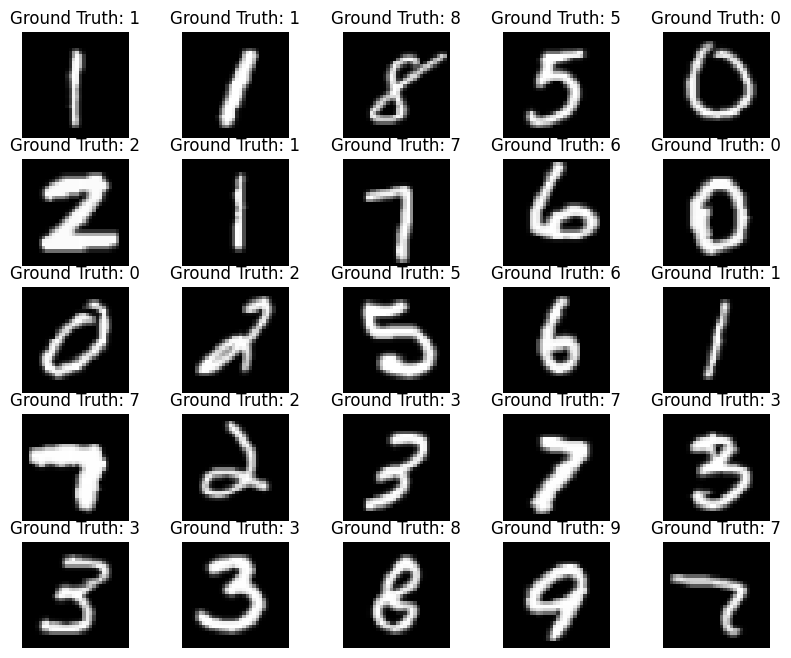

In [7]:
#plot some training examples with ground truth 
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img = train_data[sample_idx]
    label = train_target[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Ground Truth: {}".format(train_target[sample_idx]))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
model = LeNet5(num_classes=10)

In [16]:
train_data[0].size()

torch.Size([1, 32, 32])

In [9]:
x = train_data[0]

In [10]:
output = model(x)

In [11]:
print(output)

tensor([[0.1103, 0.1081, 0.0920, 0.0980, 0.0929, 0.1158, 0.0844, 0.0970, 0.0939,
         0.1076]], grad_fn=<SoftmaxBackward0>)


In [12]:
what, predicted_classes = torch.max(output, 1)

In [13]:
print(what)
print(predicted_classes)

tensor([0.1158], grad_fn=<MaxBackward0>)
tensor([5])


In [47]:
output.size()

torch.Size([1, 10])

## Model training

First, we train our model using LeNet5 (and then using AlexNet). The model was trained using batchez of size 100 and 150 epochs. Moreover, for each model, we use different optimizers : ...

In [ ]:
#define neural network's parameters 
epochs = 150
batch_size = 100
learning_rate = 1e-1

In [ ]:
#create a function that train the model, 
def train_model(model, train_input, train_target, epochs, batch_size, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    #We should change the above line because we will use different optimizers
    

    for e in range(epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            loss = criterion(output, train_target.narrow(0, b, batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        
        print('nb. of epochs: {:d} and loss : {:.03f}'.format(e, acc_loss))

In [ ]:
#this function compute the test error in fraction format 
def compute_test_errors(model, data_input, data_target, batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch_size):
        output = model(data_input.narrow(0, b, batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(batch_size):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return (nb_data_errors-data_input.size(0))/data_input.size(0)

Let's train and test our first model

In [ ]:
#training the model 
num_classes = 10
model = LeNet5(num_classes).to(device)
train_model(model, train_data, train_target, epochs, batch_size, learning_rate)
#computing train and test errors 
train_error = compute_test_errors(model, train_data, train_target, batch_size)
print("train error:", train_error)

test_error = compute_test_errors(model, test_data, test_target, batch_size)
print("test error", test_error)


